In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from loguru import logger
import pickle
from sklearn.utils.fixes import parse_version, sp_version
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import defaultdict

from source.utils.file_read import read_csv_file, filter_data, replace_nan_values
from source.utils.generate_timestamp import generate_timestamps
from source.simulation.submission_module import submission_forecasters
from source.simulation.buyer_module import prepare_buyer_data
from source.plots.display_contributions import permutation_pivot_data, lasso_coefs_pivot_data
from source.assessment_contributions import compute_forecasters_contributions
from source.ml_engine import create_ensemble_forecasts
from source.simulation.helpers_simulation import update_dict_weights, compute_coefficients
from source.utils.session_ml_info import delete_previous_day_pickle

solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [2]:
from config.simulation_setting import Simulation, WeightedAvg, Stack

sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params

In [3]:
# set random seed
np.random.seed(sim_params['random_seed'])

# read csv file
df_processed = read_csv_file(sim_params['csv_filename'], sim_params['list_columns'], sim_params['starting_period'], sim_params['ending_period'])

# replace NaN values
if sim_params['replace_nan']:
    df_processed = replace_nan_values(sim_params, df_processed)

# remove previous day pickle file
logger.info(' ')
delete_previous_day_pickle()

# initialize dictionaries to store contributions
avg_permutation_contributions = defaultdict(dict)
avg_shapley_contributions = defaultdict(dict)
avg_coefficients_contributions = defaultdict(dict)

# set buyer name
buyer_name = sim_params['buyer_resource_name']

# loop over test days
for i in tqdm(range(sim_params['num_test_days']), desc='Testing Days'):

    # generate timestamps train and prediction
    start_training_timestamp, end_training_timestamp, start_prediction_timestamp, end_prediction_timestamp = generate_timestamps(sim_params['start_training'], i, sim_params['window_size'])

    if i >= ens_params['day_calibration'] and ens_params['conformalized_qr']:
        day_calibration = ens_params['day_calibration']
        start_training_timestamp = start_training_timestamp - pd.Timedelta(f'{day_calibration}day')

    # trimming data for training and testing
    df_train = filter_data(df_processed, start_training_timestamp, end_training_timestamp, string = 'training')
    df_test = filter_data(df_processed, start_prediction_timestamp, end_prediction_timestamp, string = 'testing')

# # ----------------------------> FORECASTERS SUBMISSION <----------------------------

    df_market, df_train, df_test = submission_forecasters(sim_params, df_train, df_test)   

# # ----------------------------> MARKET OPERATOR DATA <----------------------------

    df_buyer, forecast_range = prepare_buyer_data(df_train, df_test, start_prediction_timestamp, end_prediction_timestamp)

# # ----------------------------> PREDICO PLATFORM ML ENGINE <----------------------------

# # ----------------------------> ENSEMBLE FORECASTS <----------------------------

    results_ensemble_forecasts = create_ensemble_forecasts(ens_params=ens_params,
                                                            df_buyer=df_buyer, 
                                                            df_market=df_market,
                                                            end_training_timestamp=end_training_timestamp,
                                                            forecast_range = forecast_range,
                                                            challenge_usecase='simulation',
                                                            simulation=True)
    

    # # ----------------------------> Forecasters Contribution Assessment <----------------------------

    if sim_params['contribution_assessment']:    

        # # ----------------------------> FORECASTERS PERMUTATION CONTRIBUTIONS <----------------------------
        ens_params['contribution_method'] = 'permutation'
        contr_mthd = ens_params['contribution_method']
        logger.info(' ')
        logger.opt(colors = True).info(f'<blue> -----------------> Forecasters {contr_mthd} contributions computed </blue>')
        y_test = df_test['measured'].values
        iter_permutation_contributions = compute_forecasters_contributions(buyer_name, ens_params, y_test, forecast_range)
        avg_permutation_contributions = update_dict_weights(avg_permutation_contributions, iter_permutation_contributions, iteration=i)

        # # ----------------------------> FORECASTERS SHAPLEY CONTRIBUTIONS <----------------------------
        ens_params['contribution_method'] = 'shapley'
        contr_mthd = ens_params['contribution_method']
        logger.info(' ')
        logger.opt(colors = True).info(f'<blue> -----------------> Forecasters {contr_mthd} contributions compute </blue>')
        y_test = df_test['measured'].values
        iter_shapley_contributions = compute_forecasters_contributions(buyer_name, ens_params, y_test, forecast_range)
        avg_shapley_contributions = update_dict_weights(avg_shapley_contributions, iter_shapley_contributions, iteration=i)

        # # ----------------------------> FORECASTERS COEFFICIENTS CONTRIBUTIONS <----------------------------
        if ens_params['model_type'] == 'LR':
            logger.info(' ')
            logger.opt(colors = True).info('<blue> -----------------> Forecasters coefficients contributions computed </blue>')
            with open(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/{buyer_name}_previous_day.pickle', 'rb') as handle:
                previous_day = pickle.load(handle)
            iter_coefficients_contributions = compute_coefficients(ens_params, previous_day)
            avg_coefficients_contributions = update_dict_weights(avg_coefficients_contributions, 
                                                                iter_coefficients_contributions, 
                                                                iteration=i)

    ## ----------------------------> SAVE AVG CONTRIBUTION AS PICKLE FILES <----------------------------

    # # save permutation contributions
    # with open(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/{buyer_name}_avg_permutation_contributions.pickle', 'wb') as handle:
    #     pickle.dump(avg_permutation_contributions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # # save shapley contributions
    # with open(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/{buyer_name}_avg_shapley_contributions.pickle', 'wb') as handle:
    #     pickle.dump(avg_shapley_contributions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # # save coefficients contributions
    # with open(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/{buyer_name}_avg_coefficients_contributions.pickle', 'wb') as handle:
    #     pickle.dump(avg_coefficients_contributions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Clear output
    clear_output(wait=True)

    import time
    time.sleep(20)

Testing Days: 100%|██████████| 3/3 [02:16<00:00, 45.48s/it]


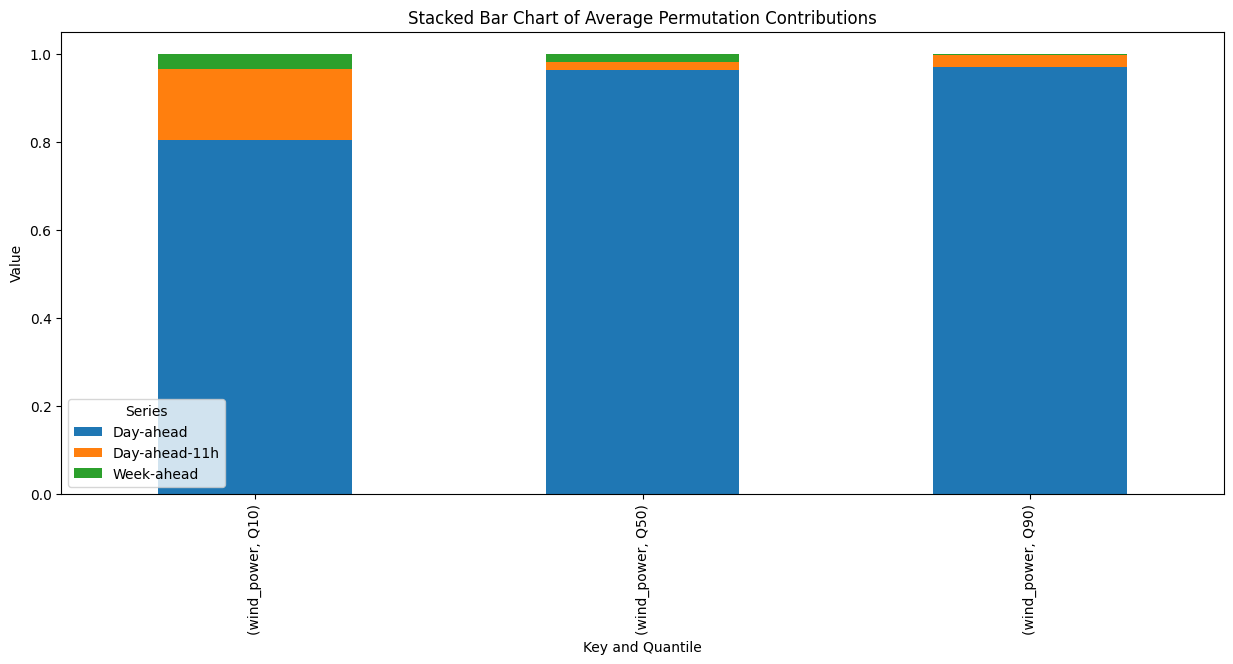

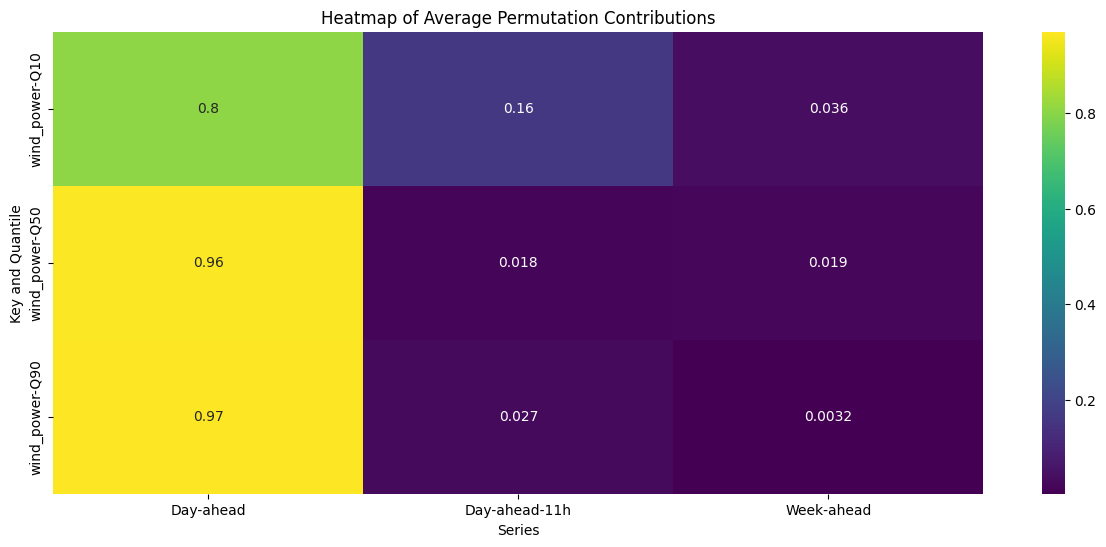

In [4]:
df_pivot = permutation_pivot_data(sim_params, avg_permutation_contributions)

# Plot the stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.xlabel('Key and Quantile')
plt.ylabel('Value')
plt.title('Stacked Bar Chart of Average Permutation Contributions')
plt.show()

# Plot the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(df_pivot, annot=True, cmap='viridis')
plt.xlabel('Series')
plt.ylabel('Key and Quantile')
plt.title('Heatmap of Average Permutation Contributions')
plt.show()

if sim_params['save_scenario_contributions']:
    type_score = 'permutation'
    scenario = sim_params['scenario']
    df_pivot.to_csv(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/df_pivot_{scenario}_{type_score}.csv')

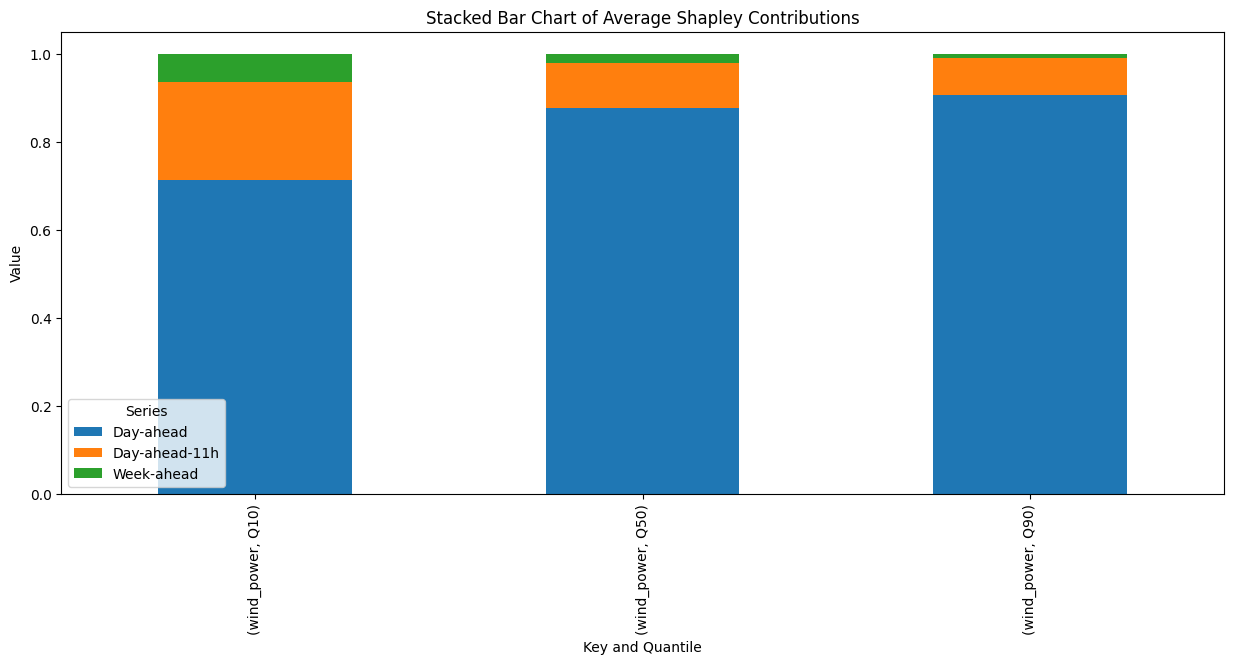

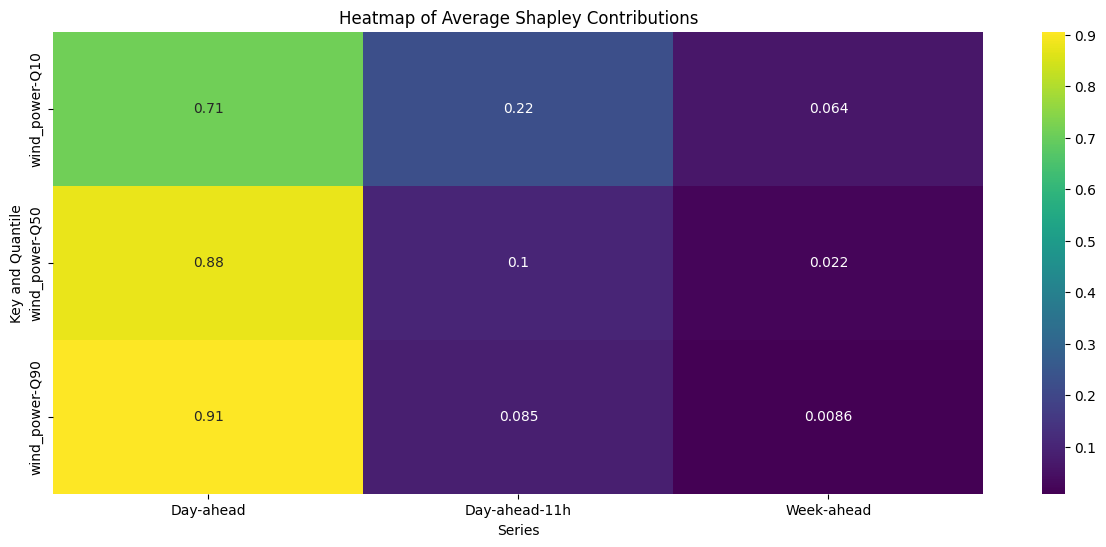

In [5]:
df_pivot = permutation_pivot_data(sim_params, avg_shapley_contributions)

# Plot the stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.xlabel('Key and Quantile')
plt.ylabel('Value')
plt.title('Stacked Bar Chart of Average Shapley Contributions')
plt.show()

# Plot the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(df_pivot, annot=True, cmap='viridis')
plt.xlabel('Series')
plt.ylabel('Key and Quantile')
plt.title('Heatmap of Average Shapley Contributions')
plt.show()

if sim_params['save_scenario_contributions']:
    type_score = 'permutation'
    scenario = sim_params['scenario']
    df_pivot.to_csv(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/df_pivot_{scenario}_{type_score}.csv')

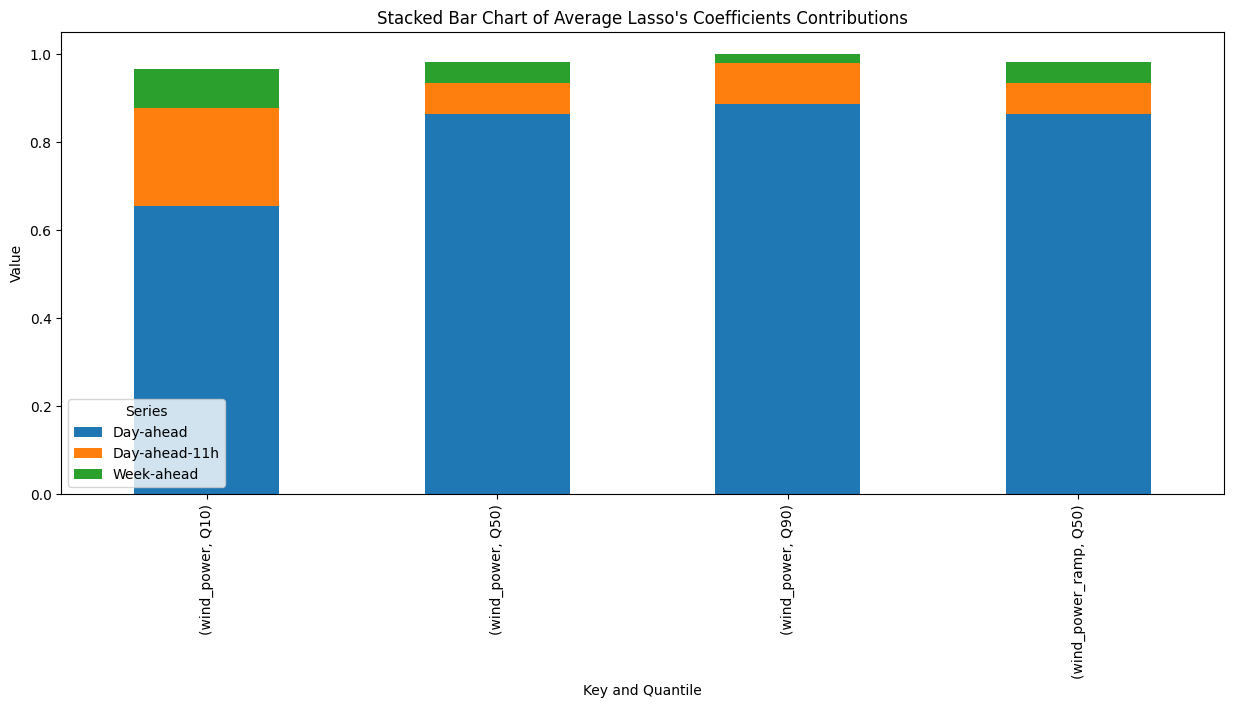

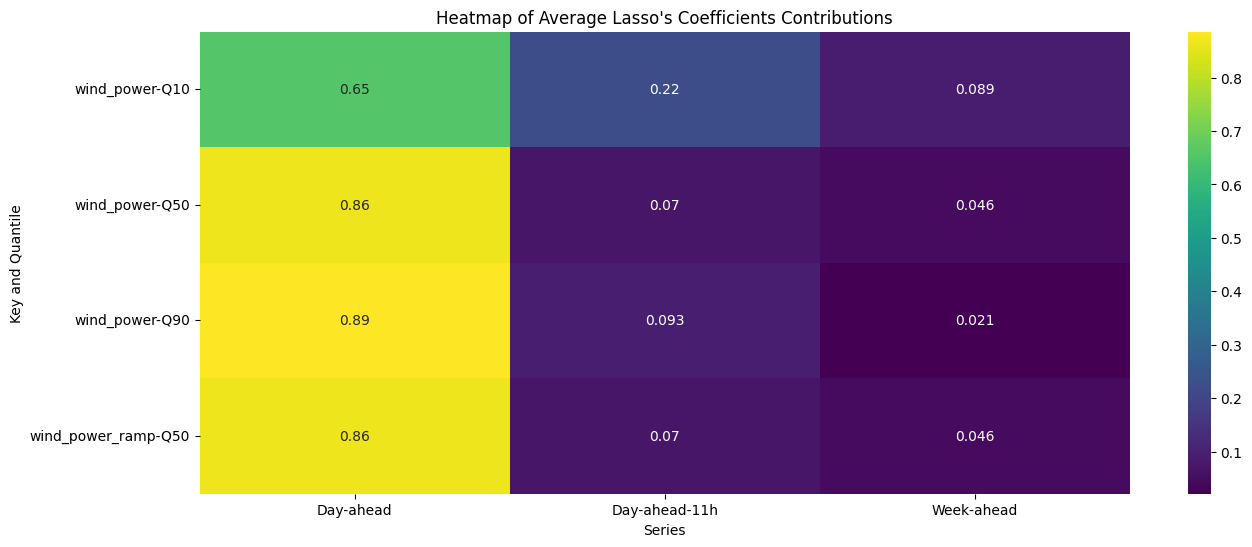

In [6]:
df_pivot = lasso_coefs_pivot_data(sim_params, avg_coefficients_contributions)

# Plot the stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.xlabel('Key and Quantile')
plt.ylabel('Value')
plt.title("Stacked Bar Chart of Average Lasso's Coefficients Contributions")
plt.show()

# Plot the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(df_pivot, annot=True, cmap='viridis')
plt.xlabel('Series')
plt.ylabel('Key and Quantile')
plt.title("Heatmap of Average Lasso's Coefficients Contributions")
plt.show()

if sim_params['save_scenario_contributions']:
    type_score = 'coefs'
    scenario = sim_params['scenario']
    df_pivot.to_csv(f'/Users/gio/Desktop/Elia-RES-Forecasting/info_model/df_pivot_{scenario}_{type_score}.csv')